# Fine-tuning SAM on Satellite Images for Street Segmentation

Our approach is based on reusing the pretrained SAM Vision Transformer, more specifically using the image encoder and discarding the prompt encoder and mask decoder. 

Instead we will try out a combination of different Custom Encoder thats we use on the encoded images. 

We will try to use different approaches for the Decocer: 

1. Conv/Deconv based approach
2. Fully connected MLP's
3. Same as the mask decoder? 
4. Transformer, ViT? 


Furthermore things that can be modified are how many last layers of the SAM encoder are also fine tuned? 
Possibly just finetune them, after a while of training the newly initialized decoder. 

We will work with a lr schedule that reduces on plateau.

Loss function? 

https://www.kaggle.com/code/rejpalcz/best-loss-function-for-f1-score-metric

Lock into this link above: best metric to optimize for non differentiable f1 metric.

---
### Loss function: 
- F1-Loss: https://pytorch.org/torcheval/stable/generated/torcheval.metrics.functional.multiclass_f1_score.html
---
### Learning rate:
- really small values
- reduceLROnPlateau(optimizer, 'max', patience=reduce_patience, verbose=verbose, factor=reduce_factor)
- cosine annealing


In [1]:
import torch
import numpy as np
import random

seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True


## Loading the dataset

In [2]:
# written by Jannek Ulm 16.5.2024
# code was inspired by the following sources: https://github.com/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb

from utils.image_loading import * 
from utils.torch_device import *
from custom_datasets import Sat_Mask_Dataset, Sat_Only_Image_Dataset

device = get_torch_device(allow_mps=True)
print("using device:",device)

###########

original_data = {}
original_data["images"] =load_training_images()
original_data["masks"] = load_groundtruth_images()

city_names = ["boston","nyc","zurich"]
custom_data = {"images":[],"masks":[]} # stores images and gt masks

for name in city_names:
    custom_data["images"].extend(load_training_images(name))
    custom_data["masks"].extend(load_groundtruth_images(name))

custom_data["images"] = custom_data["images"][0:1000]
custom_data["masks"] = custom_data["masks"][0:1000]

assert (len(custom_data["images"]) == len(custom_data["masks"]))


print("the raw custom dataset contains",len(custom_data["images"]),"images")

print("custom ds: (min,mean,max) street ratio",get_street_ratio_mmm(custom_data["masks"]))
print("orig ds: (min,mean,max) street ratio",get_street_ratio_mmm(original_data["masks"]))

# create a dataset
custom_data_set = Sat_Mask_Dataset(custom_data["images"], custom_data["masks"],min_street_ratio=0.01,max_street_ratio=1.0)
original_data_set = Sat_Mask_Dataset(original_data["images"],original_data["masks"])
print("after cleanup, the dataset now contains",len(custom_data_set),"images")


# submission kaggle dataset

kaggle_submission_images = load_test_images()
submission_data_set = Sat_Only_Image_Dataset(kaggle_submission_images)


/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <CDAC6E34-8608-3E70-8B2F-32BCD38E90FB> /Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. S

using device: mps
the raw custom dataset contains 1000 images
custom ds: (min,mean,max) street ratio (0.0, 0.1381940624999999, 0.72180625)
orig ds: (min,mean,max) street ratio (0.008968750000000001, 0.17797695312500006, 0.40426875)
Initialzed dataset, checked for min,max street ratio. Discarded %: 0.104  num discarded: 104
Initialzed dataset, checked for min,max street ratio. Discarded %: 0.0  num discarded: 0
after cleanup, the dataset now contains 896 images


In [3]:
dataset = custom_data_set
print(dataset[0][0].shape, dataset[0][0].dtype, dataset[0][0].mean(), dataset[0][0].min(), dataset[0][0].max())
print(dataset[0][1].shape, dataset[0][1].dtype, dataset[0][1].mean(), dataset[0][1].min(), dataset[0][1].max())

torch.Size([3, 1024, 1024]) torch.float32 tensor(133.7138) tensor(1.) tensor(254.)
torch.Size([1, 1024, 1024]) torch.float32 tensor(0.3802) tensor(0.) tensor(1.)


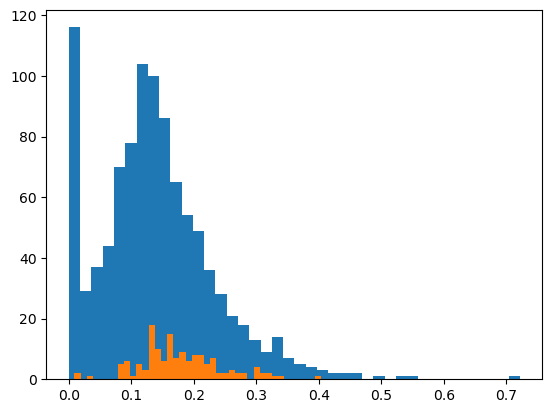

In [4]:
# plot the street ratio distribution of the dataset

custom_ratios = get_street_ratio_distr(custom_data["masks"])
original_ratios = get_street_ratio_distr(original_data["masks"])

plt.hist(custom_ratios,40)
plt.hist(original_ratios,40)
plt.show()

img:  (1024, 1024, 3) uint8 1 254 133.7029275894165
mask2:  (1024, 1024, 1) uint8 0 255
cmb:  (1024, 1024, 3) uint8 0 255 119.07334073384602


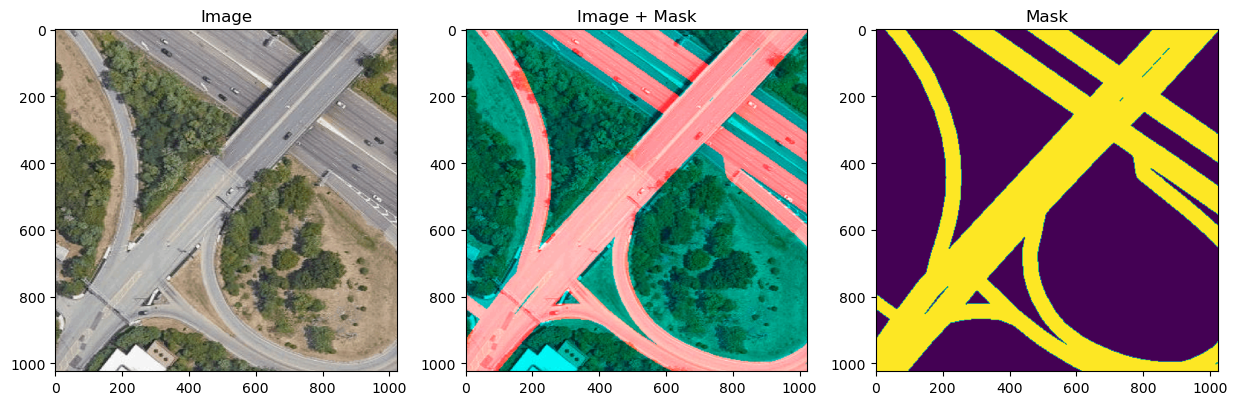

0 255 0.0 1.0


In [5]:
# make sure the dataset loading works as planned: 

import matplotlib.pyplot as plt

# get some random training images
idx = 0
image, mask = custom_data_set[idx]

img = np.array(image).astype(np.uint8)
# swap first and third dimension
img = np.swapaxes(img, 0, 2)
mask = np.array(mask)
mask = np.swapaxes(mask, 0, 2)

# 1x2 plot: 
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(img)

# image + mask overlay
plt.subplot(1, 3, 2)
plt.title("Image + Mask")
print("img: ",img.shape,img.dtype,img.min(),img.max(),img.mean())
mask2 = (mask * 255.).astype(np.uint8)
print("mask2: ",mask2.shape,mask2.dtype,mask2.min(),mask2.max())
cmb = img
cmb[:,:,0] = mask2[:,:,0]  
print("cmb: ",cmb.shape,cmb.dtype,cmb.min(),cmb.max(),cmb.mean())
plt.imshow(cmb)

# mask
plt.subplot(1, 3, 3)
plt.title("Mask")
plt.imshow(mask)
plt.show()
print(img.min(), img.max(), mask.min(), mask.max())


## Dataloader

In [6]:
train_split = 0.8
batch_size = 1


import torch.utils.data
custom_train_dataset, custom_test_dataset = torch.utils.data.random_split(custom_data_set, [train_split, 1-train_split])
original_train_dataset, original_test_dataset = torch.utils.data.random_split(original_data_set, [train_split, 1-train_split])


print(len(custom_train_dataset), len(custom_test_dataset))

from torch.utils.data import DataLoader


# CHECK IF THE FOR MULTIPLE NUM WORKERS THE CODE WORKS AS EXPECTED
# SEEMS TO BE CAUSING ISSUES WITH LONG startup and shutdown times for each epoch

# decided to drop last to make f1/loss score mean computation easier.

original_train_dataloader = DataLoader(original_train_dataset, batch_size=batch_size, shuffle=True, drop_last=True,num_workers=4,persistent_workers=True)
original_test_dataloader = DataLoader(original_test_dataset, batch_size=batch_size, shuffle=False, drop_last=True,num_workers=4,persistent_workers=True)

original_dataloader = DataLoader(original_data_set, batch_size=batch_size, shuffle=True, drop_last=True,num_workers=4,persistent_workers=True)

# dataloader for submission dataset: 
submission_dataloader = DataLoader(submission_data_set, batch_size=batch_size, shuffle=False, drop_last=False,num_workers=4,persistent_workers=True)

custom_train_dataloader = DataLoader(custom_train_dataset, batch_size=batch_size, shuffle=True, drop_last=True,num_workers=4,persistent_workers=True)
custom_test_dataloader = DataLoader(custom_test_dataset, batch_size=batch_size, shuffle=False, drop_last=True,num_workers=4,persistent_workers=True)

717 179


## Loading the model

In [7]:

############ (CUSTOM SAM (stored in repo))
from custom_segment_anything.segment_anything import sam_model_registry
from custom_segment_anything.segment_anything.CUSTOM_SAM import *

# load the model from checkpoints on disk:
def load_sam_decoder_model_from_checkpoint(checkpoint_idx:int, device,decoder,encoder_finetune_num_last_layers=6):
    sam_checkpoint_path = "custom_segment_anything/model_checkpoints/"
    # base, large, huge checkpoints. 
    checkpoint_names = ["vit_b","vit_l","vit_h"]
    checkpoints = ["sam_vit_b_01ec64.pth","sam_vit_l_0b3195.pth","sam_vit_h_4b8939.pth"]
    model_paths = [sam_checkpoint_path+checkpoint_name for checkpoint_name in checkpoints]
    sam = sam_model_registry[checkpoint_names[checkpoint_idx]](checkpoint=model_paths[checkpoint_idx])
    sam.to(device)
    model = SAM_Encoder_Custom_Decoder(sam.preprocess, sam.image_encoder,decoder=decoder.decoder,encoder_finetune_num_last_layers=encoder_finetune_num_last_layers)
    model = model.to(device)
    return model


# load the finetnued model state, if already started training. 
def load_finetuned_model(model_name,device,decoder,encoder_finetune_num_last_layers=6):
    model = load_sam_decoder_model_from_checkpoint(0,device,decoder,encoder_finetune_num_last_layers)
    finetune_path = "custom_segment_anything/model_checkpoints/finetuned/"
    model.load_state_dict(torch.load(finetune_path+name,map_location=torch.device('cpu')))
    model = model.to(device)
    return model

############################


decoder = Conv_Decoder()
name = "model_best_so_far.pth"

# select one of the checkpoints names: 
checkpoint_names = ["vit_b","vit_l","vit_h"] #-> use 0,1,2 for the specific model checkpoints
model = load_sam_decoder_model_from_checkpoint(0,device,decoder,6)
model = load_finetuned_model(name,device,decoder,6)

#print(model)

Last layer number: 176
Last layer number: 176


## Training Loop

In [8]:
print("Model loaded")
# how many trainable parameters does the model have?
print("Trainable parameters",sum(p.numel() for p in model.parameters() if p.requires_grad))
# how many total parameters does the model have?
print("Total parameters",sum(p.numel() for p in model.parameters()))

# percentage of trainable parameters
print("Percentage of trainable parameters: ")
print(sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(p.numel() for p in model.parameters()))

Model loaded
Trainable parameters 962273
Total parameters 89845729
Percentage of trainable parameters: 
0.010710280952809677


In [9]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

sam_encoder.pos_embed False
sam_encoder.patch_embed.proj.weight False
sam_encoder.patch_embed.proj.bias False
sam_encoder.blocks.0.norm1.weight False
sam_encoder.blocks.0.norm1.bias False
sam_encoder.blocks.0.attn.rel_pos_h False
sam_encoder.blocks.0.attn.rel_pos_w False
sam_encoder.blocks.0.attn.qkv.weight False
sam_encoder.blocks.0.attn.qkv.bias False
sam_encoder.blocks.0.attn.proj.weight False
sam_encoder.blocks.0.attn.proj.bias False
sam_encoder.blocks.0.norm2.weight False
sam_encoder.blocks.0.norm2.bias False
sam_encoder.blocks.0.mlp.lin1.weight False
sam_encoder.blocks.0.mlp.lin1.bias False
sam_encoder.blocks.0.mlp.lin2.weight False
sam_encoder.blocks.0.mlp.lin2.bias False
sam_encoder.blocks.1.norm1.weight False
sam_encoder.blocks.1.norm1.bias False
sam_encoder.blocks.1.attn.rel_pos_h False
sam_encoder.blocks.1.attn.rel_pos_w False
sam_encoder.blocks.1.attn.qkv.weight False
sam_encoder.blocks.1.attn.qkv.bias False
sam_encoder.blocks.1.attn.proj.weight False
sam_encoder.blocks.1.a

In [10]:

from torcheval.metrics.functional import multiclass_f1_score


def mean_f1_score_from_logits(pred,mask):
    # assume both inputs have the shape (batchsize,1, h,w), where h=w=1024
    # compute the mean for all the images
    # computes the mean over the 0-th axis
    pred_classes = torch.round(torch.sigmoid(pred))
    return mean_f1_score_from_classes(mask,pred_classes)


def mean_f1_score_from_classes(preds,masks):
    
    # assume both inputs have the shape (batchsize,1, h,w), where h=w=1024
    # this computes the f1 over the whole batch, for each image in the batch alone:
    
    # first reshape the tensors
    b_size = masks.shape[0]
    f1_acc = 0.
    size = torch.prod(torch.tensor(masks.shape[1:]))
    for i in range(b_size):
        mask = masks[i]
        pred = preds[i]
        # reshape and compute f1
        f1_acc = f1_acc + multiclass_f1_score(pred.reshape((size)),mask.reshape((size)))
        
    mean_f1 = f1_acc/b_size
    return mean_f1
'''
# test the f1 score and loss function:::
for img, mask_sample in custom_train_dataloader:
    print(mask_sample.shape)
    z = torch.zeros_like(mask_sample)
    z = (torch.rand_like(mask_sample) - 0.5) * 10
    print("correct f1 from classes",mean_f1_score_from_classes(mask_sample,mask_sample))
    print("correct f1 from logits",mean_f1_score_from_logits(z,mask_sample))
    print("mask_sample: ",mask_sample.min(),mask_sample.max(), mask_sample.mean())
    print("random z: ",z.min(),z.max(), z.mean())
    break
'''

'\n# test the f1 score and loss function:::\nfor img, mask_sample in custom_train_dataloader:\n    print(mask_sample.shape)\n    z = torch.zeros_like(mask_sample)\n    z = (torch.rand_like(mask_sample) - 0.5) * 10\n    print("correct f1 from classes",mean_f1_score_from_classes(mask_sample,mask_sample))\n    print("correct f1 from logits",mean_f1_score_from_logits(z,mask_sample))\n    print("mask_sample: ",mask_sample.min(),mask_sample.max(), mask_sample.mean())\n    print("random z: ",z.min(),z.max(), z.mean())\n    break\n'

In [15]:
import torch
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 15


#loss_function = f1_loss
import torch.nn as nn

class_weights = torch.tensor([1./0.13]).to(device)  # Example weights: adjust based on your dataset
loss_function = nn.BCEWithLogitsLoss() #(weight=class_weights)

train_loader = custom_train_dataloader
test_loader = custom_test_dataloader

train_loss = []
test_loss = []
test_f1 = []

for epoch in range(num_epochs):
    
    # training run: 
    model.train()
    running_loss = 0.0
    for image, mask in tqdm(train_loader):
        image = image.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        
        pred = model(image)
        loss = loss_function(pred,mask)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_loss.append(loss.item())
        
    print(f"Epoch: {epoch}, (train) Loss: {running_loss/len(train_loader)}")

    if epoch % 2 == 0:
        # save the model
        torch.save(model.state_dict(), f"custom_segment_anything/model_checkpoints/finetuned/model_epoch{epoch}.pth")
    # testing run: 
    model.eval()
    with torch.no_grad():
        l_acc = 0.0
        score_acc = 0.0
        
        for image,mask in tqdm(test_loader):
            image = image.to(device)
            mask = mask.to(device)
            pred = model(image)
            # compute loss and f1 score: 
            score = mean_f1_score_from_logits(pred,mask)
            loss = loss_function(pred,mask)
            
            score_acc += score.item()
            l_acc  += loss.item()
            
            test_f1.append(score.item())
            test_loss.append(loss.item())
            
        print(f"Epoch: {epoch}, (test) Loss: {l_acc/len(test_loader)}, F1-Score: {score_acc/len(test_loader)}")    
    

# save the model
torch.save(model.state_dict(), "model_tr1.pth")


100%|██████████| 717/717 [01:30<00:00,  7.91it/s]


Epoch: 0, (train) Loss: 0.21549700146522816


100%|██████████| 179/179 [00:20<00:00,  8.78it/s]


Epoch: 0, (test) Loss: 0.2338576363659771, F1-Score: 0.9079858580781095


100%|██████████| 717/717 [01:29<00:00,  7.97it/s]


Epoch: 1, (train) Loss: 0.2137523168071876


100%|██████████| 179/179 [00:20<00:00,  8.82it/s]


Epoch: 1, (test) Loss: 0.23323022882199154, F1-Score: 0.9087000322741503


100%|██████████| 717/717 [01:29<00:00,  8.01it/s]


Epoch: 2, (train) Loss: 0.21272571904992624


100%|██████████| 179/179 [00:20<00:00,  8.88it/s]


Epoch: 2, (test) Loss: 0.23189631851608528, F1-Score: 0.9090671968859667


100%|██████████| 717/717 [01:29<00:00,  8.00it/s]


Epoch: 3, (train) Loss: 0.2121301140153009


100%|██████████| 179/179 [00:20<00:00,  8.79it/s]


Epoch: 3, (test) Loss: 0.23159218712725452, F1-Score: 0.909022613943622


100%|██████████| 717/717 [01:29<00:00,  7.98it/s]


Epoch: 4, (train) Loss: 0.2115506588674905


100%|██████████| 179/179 [00:20<00:00,  8.87it/s]


Epoch: 4, (test) Loss: 0.23041023028879193, F1-Score: 0.9092363099146156


100%|██████████| 717/717 [01:29<00:00,  8.03it/s]


Epoch: 5, (train) Loss: 0.21098816952300536


100%|██████████| 179/179 [00:19<00:00,  8.95it/s]


Epoch: 5, (test) Loss: 0.23036841617366455, F1-Score: 0.9091958373618525


100%|██████████| 717/717 [01:28<00:00,  8.11it/s]


Epoch: 6, (train) Loss: 0.21050839849346353


100%|██████████| 179/179 [00:19<00:00,  9.04it/s]


Epoch: 6, (test) Loss: 0.22970262267652836, F1-Score: 0.909545281745868


100%|██████████| 717/717 [01:28<00:00,  8.15it/s]


Epoch: 7, (train) Loss: 0.21007926392172835


100%|██████████| 179/179 [00:20<00:00,  8.94it/s]


Epoch: 7, (test) Loss: 0.229825478400931, F1-Score: 0.9097264695433931


 10%|▉         | 70/717 [00:08<01:20,  8.05it/s]


KeyboardInterrupt: 

Removing the randomness in the dataset gave the following result:




-> changes now: added weight in bce loss, + batch size = 5
Epoch: 14, (train) Loss: 1.9952432917548226
100%|██████████| 35/35 [00:18<00:00,  1.89it/s]
Epoch: 14, (test) Loss: 2.09946117741721, F1-Score: 0.8935209597860064




In [11]:
#loss_function = f1_loss
import torch.nn as nn

print(device)
model = model.to(device)

class_weights = torch.tensor([1./0.13]).to(device)  # Example weights: adjust based on your dataset
loss_function = nn.BCEWithLogitsLoss() #(weight=class_weights)

from tqdm import tqdm
eval_d_loader = original_dataloader
model.eval()

with torch.no_grad():
    l_acc = 0.0
    score_acc = 0.0
    
    for image,mask in tqdm(eval_d_loader):
        image = image.to(device)
        mask = mask.to(device)
        pred = model(image)
        # compute loss and f1 score: 
        score = mean_f1_score_from_logits(pred,mask)
        loss = loss_function(torch.sigmoid(pred),mask)
        
        score_acc += score.item()
        l_acc  += loss.item() 
    print(f"(test) Loss: {l_acc/len(eval_d_loader)}, F1-Score: {score_acc/len(eval_d_loader)}") 

mps


  0%|          | 0/144 [00:00<?, ?it/s]/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <CDAC6E34-8608-3E70-8B2F-32BCD38E90FB> /Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to 

(test) Loss: 0.691081301205688, F1-Score: 0.8829053247140514


SAM model + Custom Decoder set to EVAL mode
torch.Size([1, 1, 1024, 1024])
Np arr shape:  (1024, 1024, 1) (1024, 1024, 1)


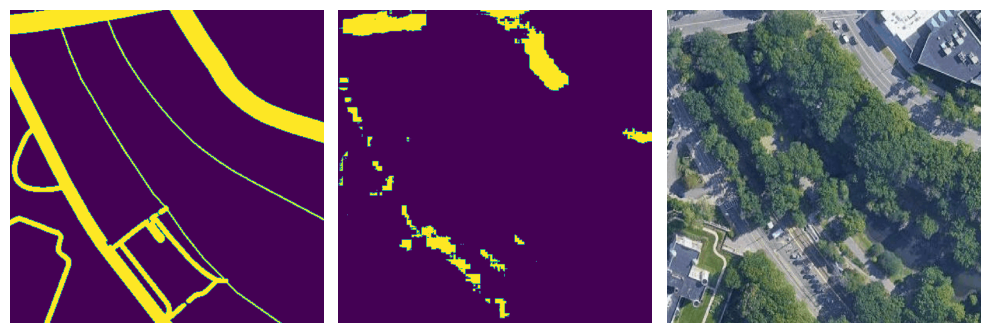

In [13]:
# TAKEN CODE FROM KAGGLE: 


model.eval()
print("SAM model + Custom Decoder set to EVAL mode")

import torch
import torch.nn.functional as F

def some_f1(y_pred, y_true):
    y_pred = torch.round(torch.sigmoid(y_pred))
    tp = torch.sum(y_true * y_pred, dim=0).float()
    tn = torch.sum((1 - y_true) * (1 - y_pred), dim=0).float()
    fp = torch.sum((1 - y_true) * y_pred, dim=0).float()
    fn = torch.sum(y_true * (1 - y_pred), dim=0).float()

    p = tp / (tp + fp + 1e-7)
    r = tp / (tp + fn + 1e-7)

    f1 = 2 * p * r / (p + r + 1e-7)
    f1[torch.isnan(f1)] = 0
    return torch.mean(f1)


sample = original_data_set[10]
inpt_0, gt_0 = sample[0], sample[1]
with torch.no_grad():
    decoder_opt = model(inpt_0.to(device).unsqueeze(0))
print(decoder_opt.shape)

decoder_opt_np = ((decoder_opt > 0.5)*1).to("cpu").numpy()[0].transpose(1,2,0)
gt_0_np = gt_0.to("cpu").numpy().transpose(1,2,0)
print("Np arr shape: ", decoder_opt_np.shape, gt_0_np.shape)

temp_img_np = inpt_0.to("cpu").numpy()
temp_img_np = np.transpose(temp_img_np, [1,2,0])
temp_img_np = temp_img_np.astype(np.uint8)

# Create a figure with one row and two columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
# Display img1 on the first subplot
axs[0].imshow(gt_0_np)
# Hide the axes of the first subplot
axs[0].axis('off')

# Display img2 on the second subplot
axs[1].imshow(decoder_opt_np)
# Hide the axes of the second subplot
axs[1].axis('off')

# Display img3 on the second subplot
axs[2].imshow(temp_img_np)
# Hide the axes of the second subplot
axs[2].axis('off')

# Adjust the spacing between the subplots
fig.tight_layout()
# Show the figure
plt.show()

train_loss [0.3965787887573242, 0.12018749862909317, 0.23872056603431702, 0.23244962096214294, 0.11433089524507523, 0.15975430607795715, 0.20201651751995087, 0.22881871461868286, 0.11839333176612854, 0.24870845675468445, 0.06967374682426453, 0.4528961777687073, 0.8114510774612427, 0.2263968288898468, 0.2546307444572449, 0.13477548956871033, 0.37603819370269775, 0.2019737958908081, 0.28509336709976196, 0.14712432026863098, 0.27096202969551086, 0.18563762307167053, 0.1638604998588562, 0.10320497304201126, 0.06472783535718918, 0.15687593817710876, 0.16214516758918762, 0.21176084876060486, 0.28359296917915344, 0.14937394857406616, 0.26693928241729736, 0.2993077039718628, 0.2139502316713333, 0.06423385441303253, 0.21209537982940674, 0.21898487210273743, 0.12792176008224487, 0.1340467631816864, 0.2666630148887634, 0.3356512188911438, 0.17380964756011963, 0.09905114024877548, 0.15280422568321228, 0.29099375009536743, 0.27722108364105225, 0.3126955032348633, 0.10534405708312988, 0.171713039278

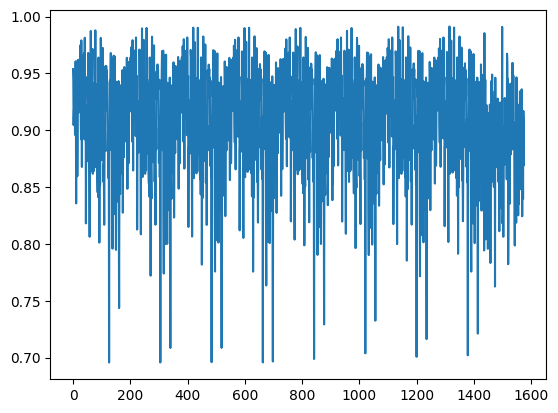

In [19]:
print("train_loss",train_loss)
print("test loss", test_loss)
print("test_f1",test_f1)


plt.plot(test_f1)
plt.show()

In [20]:
#torch.save(model.state_dict(), "model_best_so_far.pth")

# Making a Submission: 

First run the model over the submission dataloader, generate all the images. Then transform the 1024x1024 images back to the required format and store them on disk.



In [14]:
import torch.nn as nn

from tqdm import tqdm

model.eval()

predictions = []

with torch.no_grad():
    for image in tqdm(submission_dataloader):
        image = image.to(device)
        pred = model(image)
        predictions.append(pred)

  0%|          | 0/144 [00:00<?, ?it/s]/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <CDAC6E34-8608-3E70-8B2F-32BCD38E90FB> /Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to 

In [39]:
print(len(predictions), predictions[0].shape)
# go over all predictions and convert the logits to predictions:

path = "submissions/sam/cnn_decoder/"

counter = 144
for pred in predictions:
    pred = pred.squeeze()

    # pred is torch vector of shape (1024,1024)
    # convert to image
    pred = torch.round(torch.sigmoid(pred))
    pred = torch.zeros_like(pred)
    # compress to 400x400
    pred = F.interpolate(pred.unsqueeze(0).unsqueeze(0), size=(400,400), mode='nearest')
    #print(pred.shape)
    # pred is now torch vector of shape (1,1,400,400)
    # convert to numpy
    pred = pred.squeeze().squeeze().to("cpu").numpy()
    #print(pred.shape)
    # pred is now numpy vector of shape (400,400)
    # store as png to disk
    pred = (pred * 255).astype(np.uint8)
    # add 2 other color channels
    pred = np.stack([pred,pred,pred],axis=2)
    #print(pred.shape)
    # save to disk
    #plt.imshow(pred)
    #plt.show()
    plt.imsave(path+"mask_"+str(counter)+".png", pred)
    counter += 1
    #break


    # and store to disk with name: 


144 torch.Size([1, 1, 1024, 1024])


# Show images from submission dataset with their prediction:

SAM model + Custom Decoder set to EVAL mode
torch.Size([1, 1, 1024, 1024])
Np arr shape:  (1024, 1024, 1)


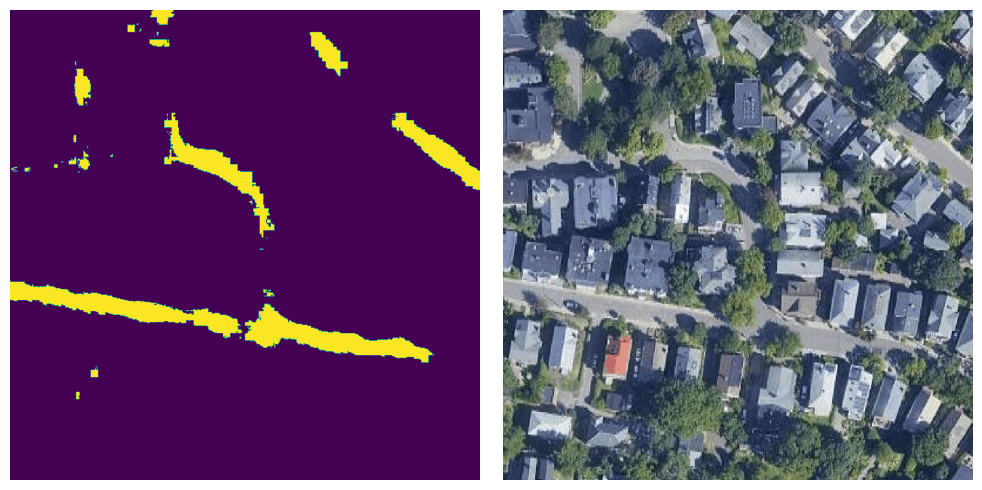

In [28]:
# TAKEN CODE FROM KAGGLE: 


model.eval()
print("SAM model + Custom Decoder set to EVAL mode")

import torch
import torch.nn.functional as F

 
inpt_0 = submission_data_set[2]
with torch.no_grad():
    decoder_opt = model(inpt_0.to(device).unsqueeze(0))
print(decoder_opt.shape)

decoder_opt_np = ((decoder_opt > 0.5)*1).to("cpu").numpy()[0].transpose(1,2,0)
print("Np arr shape: ", decoder_opt_np.shape)

temp_img_np = inpt_0.to("cpu").numpy()
temp_img_np = np.transpose(temp_img_np, [1,2,0])
temp_img_np = temp_img_np.astype(np.uint8)

# Create a figure with one row and two columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display img2 on the second subplot
axs[0].imshow(decoder_opt_np)
# Hide the axes of the second subplot
axs[0].axis('off')

# Display img3 on the second subplot
axs[1].imshow(temp_img_np)
# Hide the axes of the second subplot
axs[1].axis('off')

# Adjust the spacing between the subplots
fig.tight_layout()
# Show the figure
plt.show()